### 1. 랜덤포레스트 개요 및 실습
> __배깅__ 방식의 대표 알고리즘. __부트스트래핑__ 방식으로 데이터를 샘플링하여 여러개의 결정트리 알고리즘으로 예측  
  - 장점 : 앙상블 알고리즘 중 비교적 빠른 수행속도, 높은 예측성능. 트리 계열의 장점을 그대로 가지고 있음  
  - 단점 : 하이퍼파라미터가 너무 많고, 그로 인해 튜닝 시간이 너무 많이 소모 (랜덤포레스트는 그나마 적은편)

__부트스트래핑__ 이란?
- 원래 통계학에서 여러개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 목적을 위한 샘플링 방식을 의미. 
- 랜덤 포레스트에서 서브세트 데이터 건수는 몇개의 __개별 데이터를 중첩__ 시킴으로써 전체 데이터 건수와 동일하게 만듬 

In [1]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    ## 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('data/human_activity/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])
    
    ## 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 dfm 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    ## dfm에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    ## 학습 피처 데이터세트와 테스트 피처 데이터를 dfm으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('data/human_activity/train/X_train.txt', sep='\s+', names = feature_name)
    X_test = pd.read_csv('data/human_activity/test/X_test.txt', sep='\s+', names = feature_name)
    
    ## 학습 레이블과 테스트 레이블 데이터를 dfm으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('data/human_activity/train/y_train.txt', sep='\s+', names = ['action'])
    y_test = pd.read_csv('data/human_activity/test/y_test.txt', sep='\s+', names = ['action'])

    ## 로드된 학습/테스트용 dfm을 모두 반환
    return X_train, X_test, y_train, y_test

In [2]:
# 사용자 행동 인식 데이터세트로 랜덤포레스트 학습

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 결정 트리에서 사용한 get_human_dataset()을 이용해 학습.테스트용 dfm 반환
X_train, X_test, y_train, y_test = get_human_dataset()

## 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 정확도: {accuracy:.4f}')

랜덤 포레스트 정확도: 0.9253


### 2. 랜덤포레스트 하이퍼 파라미터 및 튜닝

>__주요 하이퍼파라미터__
  - __n_estimators__ : __결정 트리의 개수__ 지정. 디폴트는 10. 많을수록 성능상승 기댓값이 높으나 무한히 증가하지는 않음. 또한 비례하여 수행 시간이 증가하므로 적절한 값을 찾는 것이 중요
  - __max_features__ : __예측에 사용할 피처 개수__ 지정. 디폴트는 sqrt, 즉 전체 피처의 루트를 씌운것 만큼 사용
  - 이외에도 결정트리에서 사용되는 파라미터는 동일하게 활용 됨 ex) max_depth, min_samples_leaf

In [3]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

## RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print(f'최고 예측 정확도: {grid_cv.best_score_:.4f}')

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [4]:
## n_estimator를 증가시키고 최적의 하이퍼 파라미터를 이용하여 테스트데이터 예측
rf_clf1 = RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=100, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)

print(f'예측 정확도 : {accuracy_score(pred, y_test):.4f}')

예측 정확도 : 0.9196


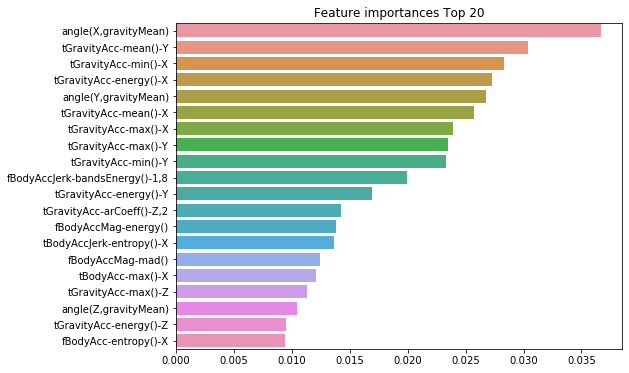

In [6]:
# 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()